In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras import applications
from keras import optimizers
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.metrics import Precision, Recall
from keras.callbacks import TensorBoard
from keras.utils import load_img, img_to_array
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Datasets/ultimatedatasetpkmn.zip'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ultimatedatasetpkmn/Vaporeon/c57ce2a9c7e84a03ba39b6a11d94119e_jpg.rf.e5eb055599726b9dc2f2dfa4190faf99.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/c5c55a0d0b714de7a6f6ed503294725a_jpg.rf.03e1dc0e03c822f7483048cb32387bd8.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/c68418580a1444049cba933870ef81f4_jpg.rf.822a0dcd145b2b541c83f5784ad260a1.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/c7a1528c69b449a2b72b26b3844c2874_jpg.rf.67aa112bbe842dbc588b0421c06592de.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/c7a1528c69b449a2b72b26b3844c2874_jpg.rf.7f07103f69a5794142ebe041e157f3cf.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/c7a1528c69b449a2b72b26b3844c2874_jpg.rf.88b3753377651ec18b11ec38ece6cc8a.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/ca0273d6d4264fa5acc99eeff0bad76b_jpg.rf.69c031152f1beeefe9de92baca8cd3a1.jpg  
  inflating: ultimatedatasetpkmn/Vaporeon/cb31e6d1083849c699f4a8257a34a797_jpg.rf.8454

In [ ]:
DATASET_DIRECTORY = '/content/ultimatedatasetpkmn'
IMAGE_SIZE = (224,224)
BATCH_SIZE = 72
SHUFFLE = True
VALIDATION_SPLIT = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    subset = 'training',
    validation_split = VALIDATION_SPLIT,
    seed = 123,
    shuffle = SHUFFLE
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    subset = 'validation',
    validation_split = VALIDATION_SPLIT,
    seed = 123,
    shuffle = SHUFFLE
)

Found 45036 files belonging to 151 classes.
Using 36029 files for training.
Found 45036 files belonging to 151 classes.
Using 9007 files for validation.


(72, 224, 224, 3)
(72, 151)


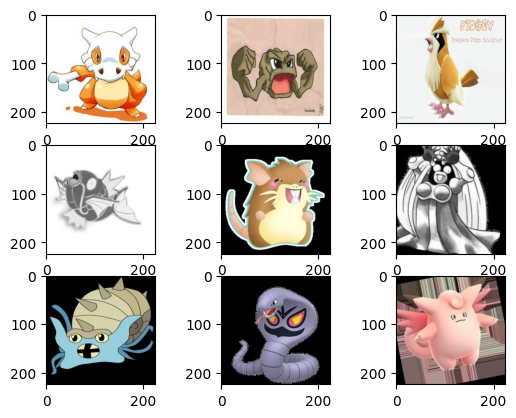

In [ ]:
from numpy import astype
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    #plt.title(labels[i])

In [ ]:
pre_trained_model = EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = pre_trained_model.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = layers.Dense(151, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss = 'categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=[CategoricalAccuracy(name='acc'),
                       TopKCategoricalAccuracy(k=3, name='top3')]
              )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,782,906 (18.25 MB)

 Trainable params: 733,335 (2.80 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=[tensorboard_callback]
)

print("Model training complete.")

Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - acc: 0.8464 - loss: 0.5619 - top3: 0.9422 - val_acc: 0.8712 - val_loss: 0.5186 - val_top3: 0.9417
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - acc: 0.8603 - loss: 0.5061 - top3: 0.9492 - val_acc: 0.8749 - val_loss: 0.4942 - val_top3: 0.9452
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - acc: 0.8725 - loss: 0.4671 - top3: 0.9558 - val_acc: 0.8818 - val_loss: 0.4704 - val_top3: 0.9486
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - acc: 0.8866 - loss: 0.4210 - top3: 0.9620 - val_acc: 0.8844 - val_loss: 0.4522 - val_top3: 0.9504
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - acc: 0.8891 - loss: 0.3955 - top3: 0.9662 - val_acc: 0.8896 - val_loss: 0.4366 - val_top3: 0.9537
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - acc: 0.8971 - loss: 0.3717 - top3: 0.9688 - val_acc: 0.8947 - val_loss: 0.4138 - val_top3: 0.9565
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - acc: 0.9085 - loss:

In [ ]:
!unzip '/content/drive/MyDrive/Datasets/demo.zip'

Archive:  /content/drive/MyDrive/Datasets/demo.zip
   creating: demo/
   creating: demo/Alakazam/
  inflating: demo/Alakazam/5c1af35732850be7cb0f1315b65fb280e5a6f610v2_hq.jpg  
  inflating: demo/Alakazam/Alakazam3.jpg  
   creating: demo/Arcanine/
  inflating: demo/Arcanine/59.png    
 extracting: demo/Arcanine/arcanine-256x256.png  
   creating: demo/Exeggutor/
  inflating: demo/Exeggutor/9086a0ee42eceec61c87733450bd2be3.jpg  
 extracting: demo/Exeggutor/l258.png  
   creating: demo/Gengar/
  inflating: demo/Gengar/gengar-pictures-dpjogkjpqnbu32wp.jpg  
  inflating: demo/Gengar/images.jpg  
   creating: demo/Jolteon/
  inflating: demo/Jolteon/images.jpg  
  inflating: demo/Jolteon/japan-pokemon-plush-toy-m-jolteon-all-star-collection.jpg  
   creating: demo/Kabutops/
  inflating: demo/Kabutops/images.jpg  
  inflating: demo/Kabutops/kabutopsjpg.jpg  
   creating: demo/Lapras/
  inflating: demo/Lapras/71xchSY+rtL.jpg  
  inflating: demo/Lapras/lapras.png  
   creating: demo/Machamp/
  

In [ ]:
IMAGES_DIRECTORY = '/content/demo/'
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16

self_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed = 123,
    crop_to_aspect_ratio=True,
)

Found 20 files belonging to 10 classes.


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names, true_label, img_size=(224,224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = 100 * np.max(predictions[0])

    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%)\nTrue: {true_label}")
    plt.show()


Processing images for class: Arcanine


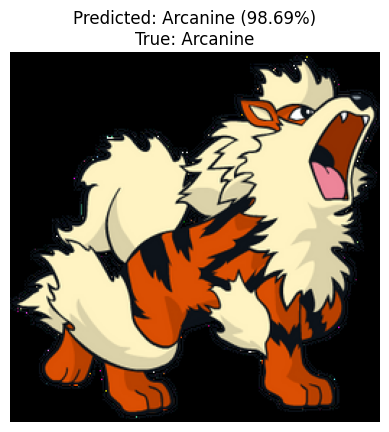

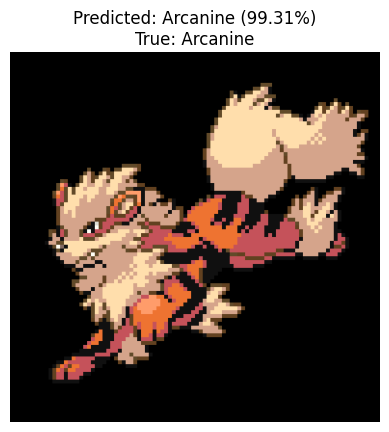


Processing images for class: Machamp


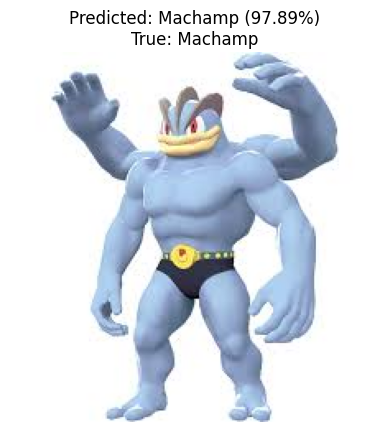

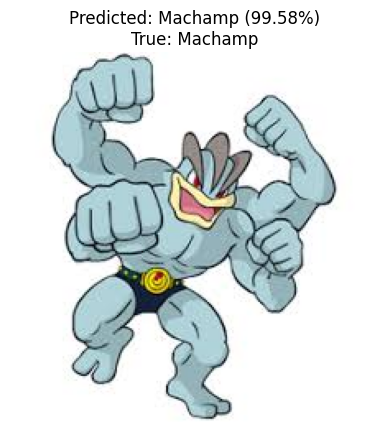


Processing images for class: Alakazam


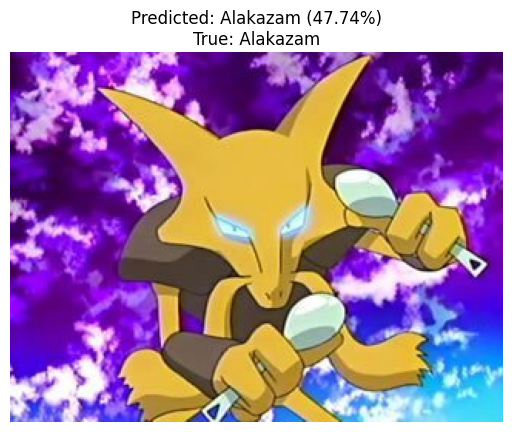

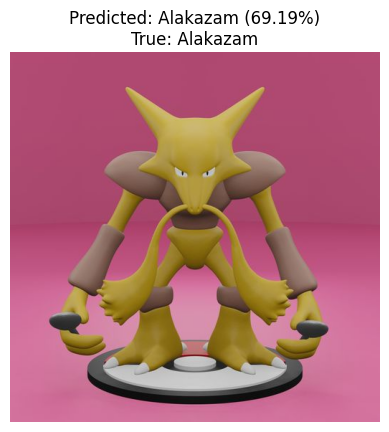


Processing images for class: Exeggutor


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


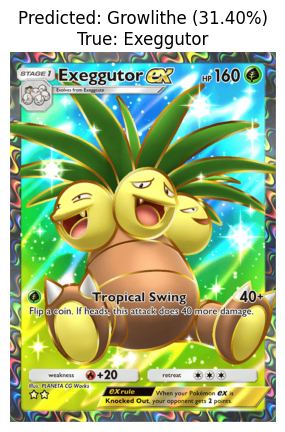

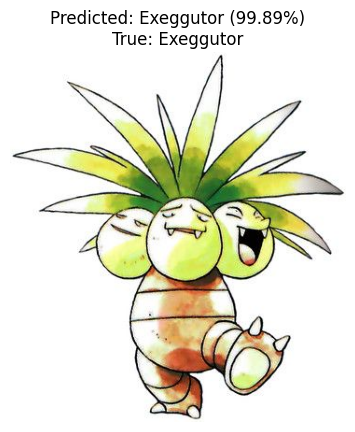


Processing images for class: Jolteon


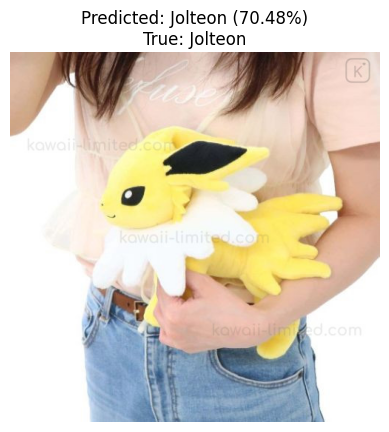

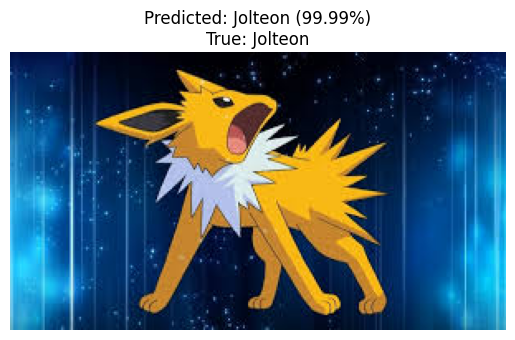


Processing images for class: Nidoking


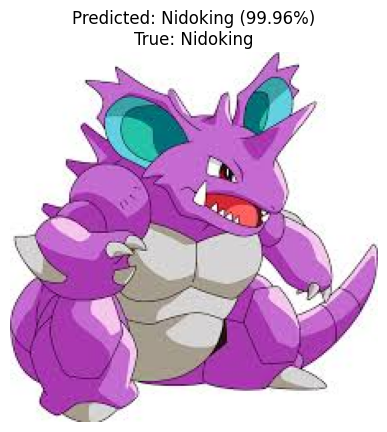

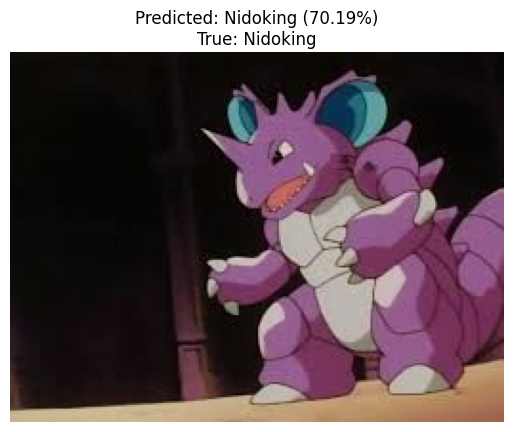


Processing images for class: Pidgeot


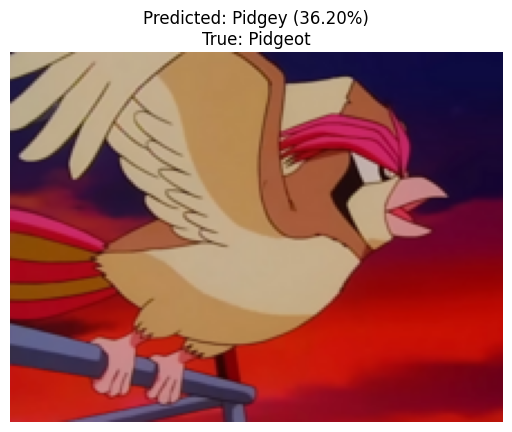

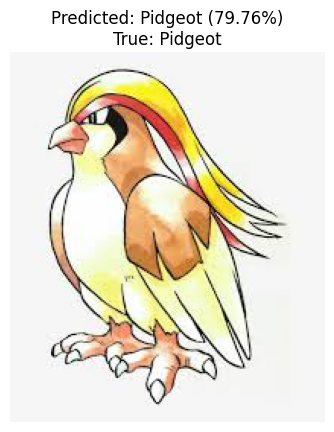


Processing images for class: Lapras


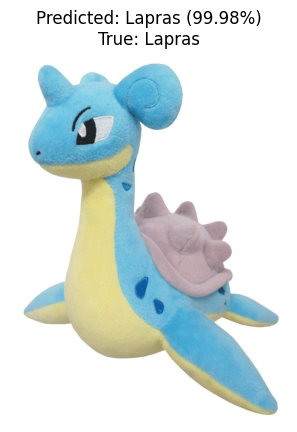

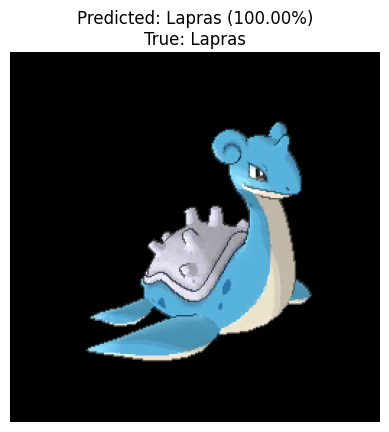


Processing images for class: Kabutops


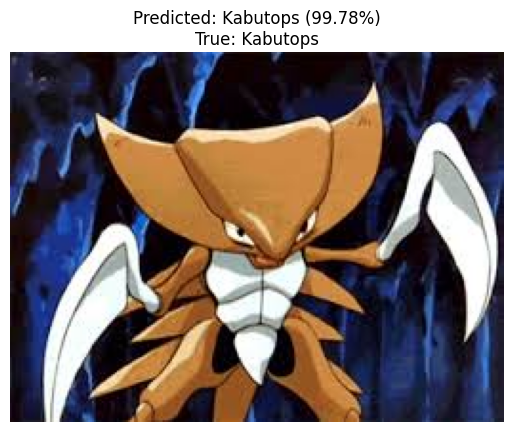

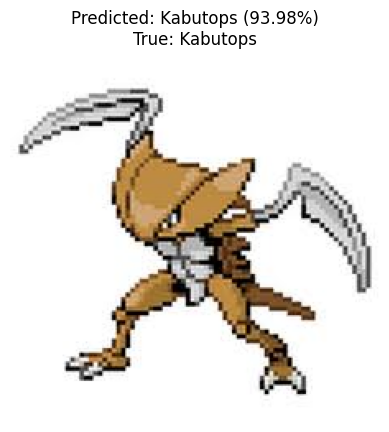


Processing images for class: Gengar


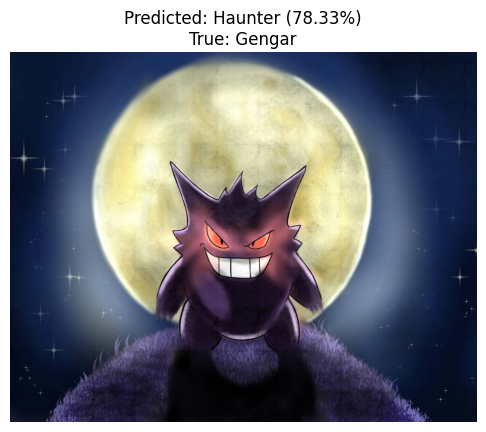

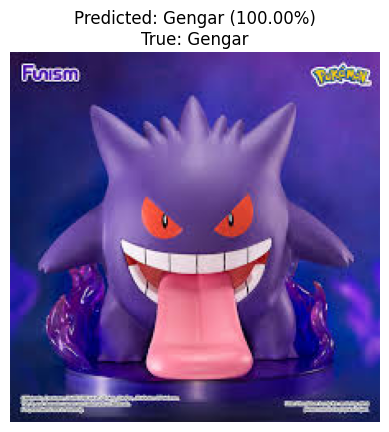

In [ ]:
import os
import matplotlib.pyplot as plt

# Ensure class_names is available from previous steps
# If train_ds is not available or recreated, this step might fail.
# Assuming train_ds.class_names is correctly populated.
class_names = train_ds.class_names

base_dir = '/content/demo/'

# Iterate through each subdirectory (which represents a class)
for class_folder in os.listdir(base_dir):
    class_folder_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_folder_path):
        true_label = class_folder # The folder name is the true label
        print(f"\nProcessing images for class: {true_label}")
        # Iterate through each image file in the class folder
        for image_file in os.listdir(class_folder_path):
            # Filter for common image extensions
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                img_path = os.path.join(class_folder_path, image_file)
                predict_image(img_path, model, class_names, true_label)
